In [1]:
!pip install -U -q transformers==4.39.3
!pip install -U -q bitsandbytes==0.43.0
!pip install -U -q accelerate==0.28.0
!pip install -U -q gradio==4.14.0

In [3]:
import torch
from transformers import pipeline, BitsAndBytesConfig

quantization_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id="llava-hf/llava-1.5-7b-hf"

# https://huggingface.co/docs/transformers/v4.39.3/en/main_classes/model#transformers.PreTrainedModel
pipe=pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config":quantization_config},device_map="auto")
pipe.device

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


device(type='cuda', index=0)

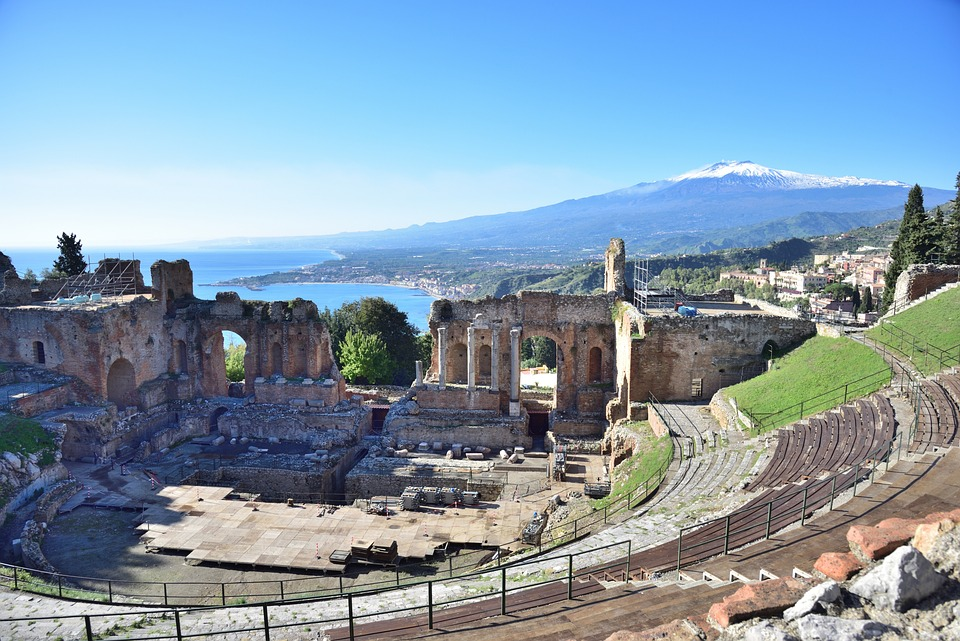

In [4]:
import requests
from PIL import Image

image_url = "https://cdn.pixabay.com/photo/2018/01/29/14/13/italy-3116211_960_720.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image

In [5]:
prompt = "USER: <image>\nDescribe this picture​​\nASSISTANT:"

# https://huggingface.co/docs/transformers/en/main_classes/text_generation#transformers.GenerationConfig
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
print(outputs[0]['generated_text'])

USER:  
Describe this picture​​
ASSISTANT: The image features a large, empty amphitheater with a stunning view of the ocean in the background. The amphitheater is surrounded by a lush green hillside, creating a picturesque scene. The area appears to be a popular tourist destination, as there are several cars parked nearby.

In addition to the cars, there are a few people scattered around the scene, likely enjoying the beautiful surroundings. The combination of the amphitheater, the ocean, and the hillside creates a serene and captivating atmosphere.


# With Gradio

In [ ]:
def update_conversation(new_message, history, image):
    
    if image is None:
        return "Please upload an image first using the widget on the left"

    conversation_starting_from_image = [[user, assistant] for [user, assistant] in history if not assistant.startswith('Please')]

    prompt = "USER: <image>\n"

    for i in range(len(history)):
        prompt+=history[i][0]+'\nASSISTANT: '+history[i][1]+"\nUSER: "

    prompt = prompt+new_message+'\nASSISTANT: '

    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200
                                                          #, "do_sample" : True,
                                                          #"temperature" : 0.7
                                                          })[0]['generated_text']

    return outputs[len(prompt)-6:]

In [ ]:
import gradio as gr

with gr.Blocks() as demo:

    with gr.Row():
        image = gr.Image(type='pil', interactive=True)
        gr.ChatInterface(update_conversation, additional_inputs=[image])

demo.launch(debug=True)

# Acknowledge
* https://towardsdatascience.com/llava-an-open-source-alternative-to-gpt-4v-ision-b06f88ce8efa